In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
%matplotlib inline
import os
import math

In [2]:
filename = '/home/xams/xams/PMT3_gain_calibration/P_series/integration_tests/P1000V_int_310-360.hdf5'

if not os.path.exists(filename):
    raise FileNotFoundError("not found")
    
store = pd.HDFStore(filename)
data= store['all_hits']
pulses = store['Pulse']
data['baseline'] = pulses[pulses['channel'] == 0]['baseline']

print(len(data))
data.dtypes

1011401


Event                       int64
area                      float64
center                    float64
channel                     int64
found_in_pulse              int64
height                    float64
index_of_maximum            int64
is_rejected                  int8
left                        int64
n_saturated                 int64
noise_sigma               float64
right                       int64
sum_absolute_deviation    float64
baseline                  float32
dtype: object

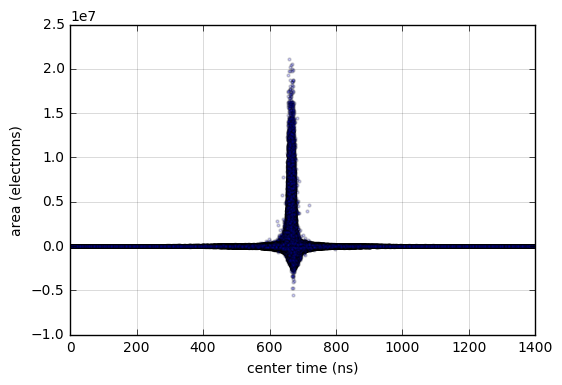

In [3]:
plt.scatter(data['center'], data['area'], s=4, alpha = 0.2)
# plt.yscale('log')
plt.xlabel("center time (ns)")
plt.ylabel("area (electrons)")
plt.grid(alpha=0.2, linestyle='-')
plt.xlim([0, 1400])
plt.show()

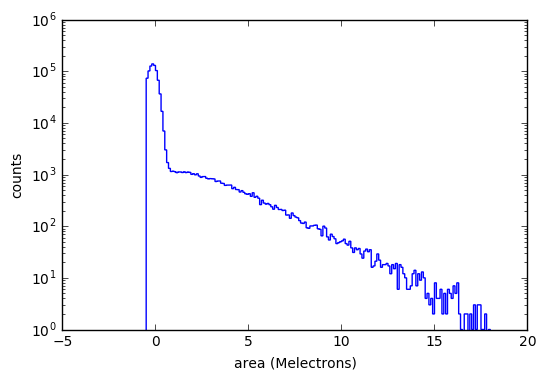

In [4]:
histboundaries = [-0.5, 18]
histbinwidth = 0.1
histbins = np.arange(histboundaries[0], histboundaries[1]+histbinwidth, histbinwidth)
centers = np.arange(histboundaries[0]+histbinwidth/2.0, histboundaries[1], histbinwidth)

melecs = data['area']/1e6

hist = plt.hist(melecs, bins=histbins, histtype='step')
counts = hist[0]
countserr = [np.sqrt(t)+0.1 for t in counts]

plt.xlabel("area (Melectrons)")
plt.ylabel("counts")
plt.yscale('log')
# plt.ylim(0,1000)
plt.show()

[  1.39238017e+05  -1.55602737e-01   2.43766544e-01   1.60937792e+03
  -2.80658547e+00   4.78949886e+00]
[  5.44806113e+02   1.06388154e-03   8.83347910e-04   1.47119297e+02
   5.88538240e-01   1.81253647e-01]
  


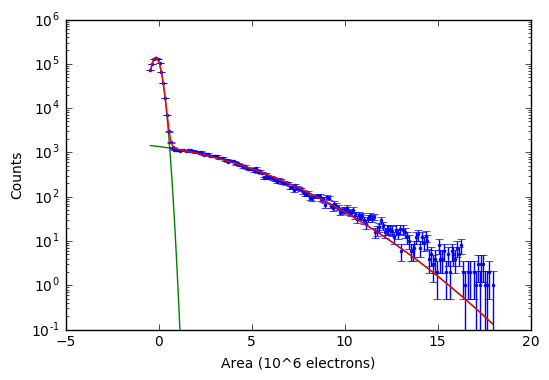

In [5]:
def doublegauss(x, a1, b1, s1, a2, b2, s2):
    return a1 * np.exp(-(x-b1)**2/(2*s1**2)) + a2 * np.exp(-(x-b2)**2/(2*s2**2))

def gauss(x, a1, b1, s1):
    return a1 * np.exp(-(x-b1)**2/(2*s1**2))

def xgauss(x, a1, b1, s1):
    return a1 * x * np.exp(-(x-b1)**2/(2*s1**2))

a1g = 1.1e5
b1g = -0.17
s1g = 0.25

a2g = 1e5
b2g = -2.3
s2g = 1.13

popt, pcov = curve_fit(doublegauss, centers, counts, sigma = countserr, p0=[a1g, b1g, s1g, a2g, b2g, s2g])
perr = np.sqrt(np.diag(pcov))
a1f, b1f, s1f, a2f, b2f, s2f = popt

print(popt)
print(perr)
print("  ")

fitcounts = [doublegauss(t, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]) for t in centers]
gescounts = [doublegauss(t, a1g, b1g, s1g, a2g, b2g, s2g) for t in centers]
noscounts = [gauss(t, popt[0], popt[1], popt[2]) for t in centers]
sigcounts = [gauss(t, popt[3], popt[4], popt[5]) for t in centers]


plt.plot(centers, noscounts, color='green', linewidth = 1)
plt.plot(centers, sigcounts, color='green', linewidth = 1)
plt.errorbar(centers, counts, yerr = countserr, fmt = '.', markersize = 4)
plt.plot(centers, fitcounts, color='red', linewidth = 1)
# plt.plot(centers, gescounts, color='black', linewidth = 1)

plt.xlabel("Area (10^6 electrons)")
plt.ylabel("Counts")
plt.yscale('log')
plt.ylim(1e-1, 10e5)
plt.xlim()
# plt.ylim(0,10e2)
# plt.ylim(0,1800)

plt.savefig('1000v.eps', format='eps')
plt.savefig('1000vtrans.eps', format='eps', transparent=True)






In [6]:
import scipy.integrate as integrate
print('noisewidth = ', s1f)
totalgral = integrate.quad(gauss, 0, np.inf, args = (a2f, b2f, s2f))[0]
totalsignal = totalgral / histbinwidth
avggain = integrate.quad(xgauss, 0, np.inf, args = (a2f, b2f, s2f))[0]/totalgral
print('totalsignal = ', totalsignal)
print('Poisson stat = ', totalsignal / len(data))
print('avggain = ', avggain)

noisewidth =  0.243766544299
totalsignal =  53895.437488589065
Poisson stat =  0.053287902116558185
avggain =  2.9626986549824066
